In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
# Upload kaggle API key file
data = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Download the dataset from kaggle
!kaggle datasets download -d frabbisw/facial-age

100% 840M/840M [00:13<00:00, 75.6MB/s]
100% 840M/840M [00:13<00:00, 63.9MB/s]


In [0]:
# Extract zipfile
import zipfile
zip_ref = zipfile.ZipFile('facial-age.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [0]:
# Remove unused classes and duplicated folder
!rm -rf /content/files/face_age/100
!rm -rf /content/files/face_age/101
!rm -rf /content/files/face_age/110
!rm -rf /content/files/face_age/face_age

In [0]:
# Modules for train-val split
import os
import numpy as np
import random
import argparse
from shutil import copyfile

In [0]:
# Train-val split function
def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    else:
        if not os.path.exists('data/train'):
            os.makedirs('data/train')
        if not os.path.exists('data/validation'):
            os.makedirs('data/validation')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('data/train', subdir)
        validation_subdir = os.path.join('data/validation', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/validation/' + subdir)

In [0]:
# Run the split function
img_train_test_split('/content/files/face_age',0.5)

Copied 41 images to data/train/034
Copied 46 images to data/validation/034
Copied 60 images to data/train/050
Copied 45 images to data/validation/050
Copied 10 images to data/train/077
Copied 9 images to data/validation/077
Copied 34 images to data/train/041
Copied 22 images to data/validation/041
Copied 46 images to data/train/049
Copied 53 images to data/validation/049
Copied 45 images to data/train/017
Copied 58 images to data/validation/017
Copied 76 images to data/train/025
Copied 80 images to data/validation/025
Copied 66 images to data/train/010
Copied 74 images to data/validation/010
Copied 53 images to data/train/065
Copied 60 images to data/validation/065
Copied 75 images to data/train/014
Copied 62 images to data/validation/014
Copied 60 images to data/train/035
Copied 61 images to data/validation/035
Copied 143 images to data/train/003
Copied 141 images to data/validation/003
Copied 25 images to data/train/070
Copied 28 images to data/validation/070
Copied 14 images to data

In [0]:
# Modules for model creation
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(96, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Label generator
TRAINING_DIR = "/content/data/train/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/content/data/validation/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

Found 4792 images belonging to 96 classes.
Found 4981 images belonging to 96 classes.


In [0]:
# Fit the model
history = model.fit(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/30
48/48 [==============================] - 135s 3s/step - loss: 4.2245 - accuracy: 0.1137 - val_loss: 4.1754 - val_accuracy: 0.1138
Epoch 2/30
48/48 [==============================] - 135s 3s/step - loss: 3.8018 - accuracy: 0.1275 - val_loss: 3.7566 - val_accuracy: 0.1331
Epoch 3/30
48/48 [==============================] - 136s 3s/step - loss: 3.3078 - accuracy: 0.1836 - val_loss: 3.6936 - val_accuracy: 0.1480
Epoch 4/30
48/48 [==============================] - 138s 3s/step - loss: 2.8866 - accuracy: 0.2350 - val_loss: 3.6527 - val_accuracy: 0.1578
Epoch 5/30
48/48 [==============================] - 135s 3s/step - loss: 2.4024 - accuracy: 0.3341 - val_loss: 3.9361 - val_accuracy: 0.1678
Epoch 6/30
48/48 [==============================] - 135s 3s/step - loss: 1.8750 - accuracy: 0.4691 - val_loss: 4.2499 - val_accuracy: 0.1554
Epoch 7/30
48/48 [==============================] - 135s 3s/step - loss: 1.3895 - accuracy: 0.6039 - val_loss: 4.4881 - val_accuracy: 0.1309
Epoch 8/30
48

<Figure size 432x288 with 0 Axes>

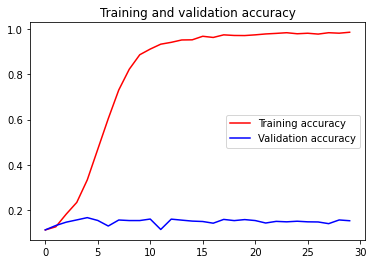

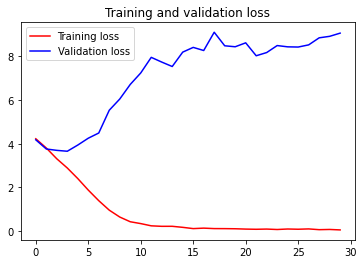

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label ='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()